In [1]:
import sys, os, datetime
sys.path.append("../../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

import brownie

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

In [4]:
tricrypto2_contract_addr = "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46"
tricrypto2_contract = init_contract(tricrypto2_contract_addr)
tricrypto2_contract

<Vyper_contract Contract '0xD51a44d3FaE010294C616388b506AcdA1bfAAE46'>

In [82]:
tricrypto2_contract_addr.lower()

'0xd51a44d3fae010294c616388b506acda1bfaae46'

In [5]:
tricrypto2_lp_token_price_contract_address = "0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950"
contract_genesis = 12821148
tricrypto2_lp_token_price_contract = init_contract(tricrypto2_lp_token_price_contract_address)
tricrypto2_lp_token_price_contract

<Vyper_contract Contract '0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950'>

In [6]:
tricrypto2_lp_token_price_contract.lp_price() * 1e-18

1848.774206266827

In [67]:
def get_lp_price_from_block(
    block_number_start: int,
    lp_price_contract: brownie.Contract,
    lp_contract: brownie.Contract,
    block_steps: int = 10000
) -> pd.DataFrame:

    current_block = brownie.web3.eth.block_number
    blocks_to_calculate = list(range(block_number_start, current_block, block_steps))
    blocks_to_calculate.append(current_block)

    data = {
        'timestamp': [],
        'block_number': [],
        'lp_token_price': [],
        'btc_price': [],
        'eth_price': [],
    }

    for block_number in blocks_to_calculate:

        block_details = brownie.web3.eth.get_block(block_identifier=block_number)
        block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])

        btc_price = lp_contract.price_oracle(0, block_identifier=block_number) * 1e-18
        eth_price = lp_contract.price_oracle(1, block_identifier=block_number) * 1e-18
        virtual_price = lp_contract.get_virtual_price(block_identifier=block_number) * 1e-18

        lp_token_price = 3 * virtual_price * (btc_price * eth_price)**(1./3)
        print(lp_token_price)

        data['timestamp'].append(block_time)
        data['block_number'].append(block_number)
        data['lp_token_price'].append(lp_token_price)
        data['btc_price'].append(btc_price)
        data['eth_price'].append(eth_price)

    df_data = pd.DataFrame(data)

    return df_data.set_index('timestamp')

In [68]:
block_start = brownie.web3.eth.block_number - 100000
df_prices = get_lp_price_from_block(
    block_number_start=block_start,
    lp_price_contract=tricrypto2_lp_token_price_contract,
    lp_contract=tricrypto2_contract,
    block_steps=1000
)
df_prices

1989.7497607168807
1995.370904303761
1970.2545641869235
1981.1944866779986
1997.218537358153
1992.9403272011793
1988.5834647750119
1974.1166891175374
1969.659881040783
1958.7302451663695
1959.4730428158691
1967.4674034361592
1973.5302899532333
1979.4389635033308
1967.0901731887238
1964.2941677265815
1960.6949727937438
1957.662771870233
1961.0003343235826
1962.8538418000708
1957.5447062399153
1936.1601704242282
1943.996876049106
1964.6644840991667
1967.2528146979676
1980.8285854979647
1976.6977153556368
1981.9253626742716
1982.757791437592
1989.002589295796
1996.849473757876
2033.4472961164263
2047.1887785596514
2045.179300936779
2040.184753052636
2053.5265329321405
2048.8050828854343
2071.9670480276613
2074.645258195113
2075.7598157452194
2068.2306840171213
2060.499672575623
2051.5950470680436
2060.2883228282535
2049.4301402378123
2052.4218647170223
2056.901331705663
2086.9685799568947
2077.7833772796444
2014.5151886288122
2015.4471771128842
2021.1679306423625
2040.3002856492521
2032.2

,block_number,lp_token_price,btc_price,eth_price
timestamp,,,,
2021-11-03 07:28:42,13542318,1989.749761,63022.853223,4553.708410
2021-11-03 11:22:53,13543318,1995.370904,63094.771896,4587.137534
2021-11-03 15:14:48,13544318,1970.254564,62005.081430,4493.609296
2021-11-03 18:52:48,13545318,1981.194487,62385.197299,4541.017977
2021-11-03 22:30:34,13546318,1997.218537,62827.100773,4619.243652
...,...,...,...,...
2021-11-18 09:44:08,13638318,1909.606877,59676.810657,4247.522127
2021-11-18 13:24:04,13639318,1901.255852,59496.324531,4204.660177
2021-11-18 17:11:30,13640318,1869.555819,58334.804697,4077.258761


Calculate Index Price:

In [69]:
seed_value = df_prices["lp_token_price"].values[0]  # total dollars
seed_num_dollars = 1/3 * seed_value
seed_num_eth = 1/3 * seed_value/df_prices.eth_price.iloc[0]
seed_num_btc = 1/3 * seed_value/df_prices.btc_price.iloc[0]

df_prices['index_price'] = 0
for idx, row in df_prices.iterrows():

    df_prices.loc[idx, 'index_price'] = (
            seed_num_dollars + seed_num_eth*row.eth_price + seed_num_btc*row.btc_price
    )

df_prices

,block_number,lp_token_price,btc_price,eth_price,index_price
timestamp,,,,,
2021-11-03 07:28:42,13542318,1989.749761,63022.853223,4553.708410,1989.749761
2021-11-03 11:22:53,13543318,1995.370904,63094.771896,4587.137534,1995.375599
2021-11-03 15:14:48,13544318,1970.254564,62005.081430,4493.609296,1970.285306
2021-11-03 18:52:48,13545318,1981.194487,62385.197299,4541.017977,1981.190728
2021-11-03 22:30:34,13546318,1997.218537,62827.100773,4619.243652,1997.234911
...,...,...,...,...,...
2021-11-18 09:44:08,13638318,1909.606877,59676.810657,4247.522127,1909.939960
2021-11-18 13:24:04,13639318,1901.255852,59496.324531,4204.660177,1901.797667
2021-11-18 17:11:30,13640318,1869.555819,58334.804697,4077.258761,1871.017800


In [72]:
df_prices['lp_token_price_diff'] = df_prices.lp_token_price.diff()
df_prices['btc_price_diff'] = df_prices.btc_price.diff()
df_prices['eth_price_diff'] = df_prices.eth_price.diff()
df_prices['index_price_diff'] = df_prices.index_price.diff()

df_prices

,block_number,lp_token_price,btc_price,eth_price,index_price,lp_token_price_diff,btc_price_diff,eth_price_diff,index_price_diff
timestamp,,,,,,,,,
2021-11-03 07:28:42,13542318,1989.749761,63022.853223,4553.708410,1989.749761,NaN,NaN,NaN,NaN
2021-11-03 11:22:53,13543318,1995.370904,63094.771896,4587.137534,1995.375599,5.621144,71.918673,33.429124,5.625838
2021-11-03 15:14:48,13544318,1970.254564,62005.081430,4493.609296,1970.285306,-25.116340,-1089.690466,-93.528238,-25.090293
2021-11-03 18:52:48,13545318,1981.194487,62385.197299,4541.017977,1981.190728,10.939922,380.115869,47.408682,10.905422
2021-11-03 22:30:34,13546318,1997.218537,62827.100773,4619.243652,1997.234911,16.024051,441.903473,78.225675,16.044183
...,...,...,...,...,...,...,...,...,...
2021-11-18 09:44:08,13638318,1909.606877,59676.810657,4247.522127,1909.939960,-7.938127,-274.576307,-33.563792,-7.778213
2021-11-18 13:24:04,13639318,1901.255852,59496.324531,4204.660177,1901.797667,-8.351025,-180.486126,-42.861950,-8.142293
2021-11-18 17:11:30,13640318,1869.555819,58334.804697,4077.258761,1871.017800,-31.700033,-1161.519834,-127.401416,-30.779867


In [73]:
df_prices['lp_token_price_diff_perc'] = 100 * df_prices.lp_token_price.diff() / df_prices.lp_token_price
df_prices['btc_price_diff_perc'] = 100 * df_prices.btc_price.diff() / df_prices.btc_price
df_prices['eth_price_diff_perc'] = 100 * df_prices.eth_price.diff() / df_prices.eth_price
df_prices['index_price_diff_perc'] = 100 * df_prices.index_price.diff() / df_prices.index_price

df_prices

,block_number,lp_token_price,btc_price,eth_price,index_price,lp_token_price_diff,btc_price_diff,eth_price_diff,index_price_diff,lp_token_price_diff_perc,btc_price_diff_perc,eth_price_diff_perc,index_price_diff_perc
timestamp,,,,,,,,,,,,,
2021-11-03 07:28:42,13542318,1989.749761,63022.853223,4553.708410,1989.749761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-03 11:22:53,13543318,1995.370904,63094.771896,4587.137534,1995.375599,5.621144,71.918673,33.429124,5.625838,0.281709,0.113985,0.728758,0.281944
2021-11-03 15:14:48,13544318,1970.254564,62005.081430,4493.609296,1970.285306,-25.116340,-1089.690466,-93.528238,-25.090293,-1.274776,-1.757421,-2.081361,-1.273434
2021-11-03 18:52:48,13545318,1981.194487,62385.197299,4541.017977,1981.190728,10.939922,380.115869,47.408682,10.905422,0.552188,0.609305,1.044010,0.550448
2021-11-03 22:30:34,13546318,1997.218537,62827.100773,4619.243652,1997.234911,16.024051,441.903473,78.225675,16.044183,0.802318,0.703364,1.693474,0.803320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-18 09:44:08,13638318,1909.606877,59676.810657,4247.522127,1909.939960,-7.938127,-274.576307,-33.563792,-7.778213,-0.415694,-0.460106,-0.790197,-0.407249
2021-11-18 13:24:04,13639318,1901.255852,59496.324531,4204.660177,1901.797667,-8.351025,-180.486126,-42.861950,-8.142293,-0.439237,-0.303357,-1.019392,-0.428137
2021-11-18 17:11:30,13640318,1869.555819,58334.804697,4077.258761,1871.017800,-31.700033,-1161.519834,-127.401416,-30.779867,-1.695592,-1.991127,-3.124683,-1.645087


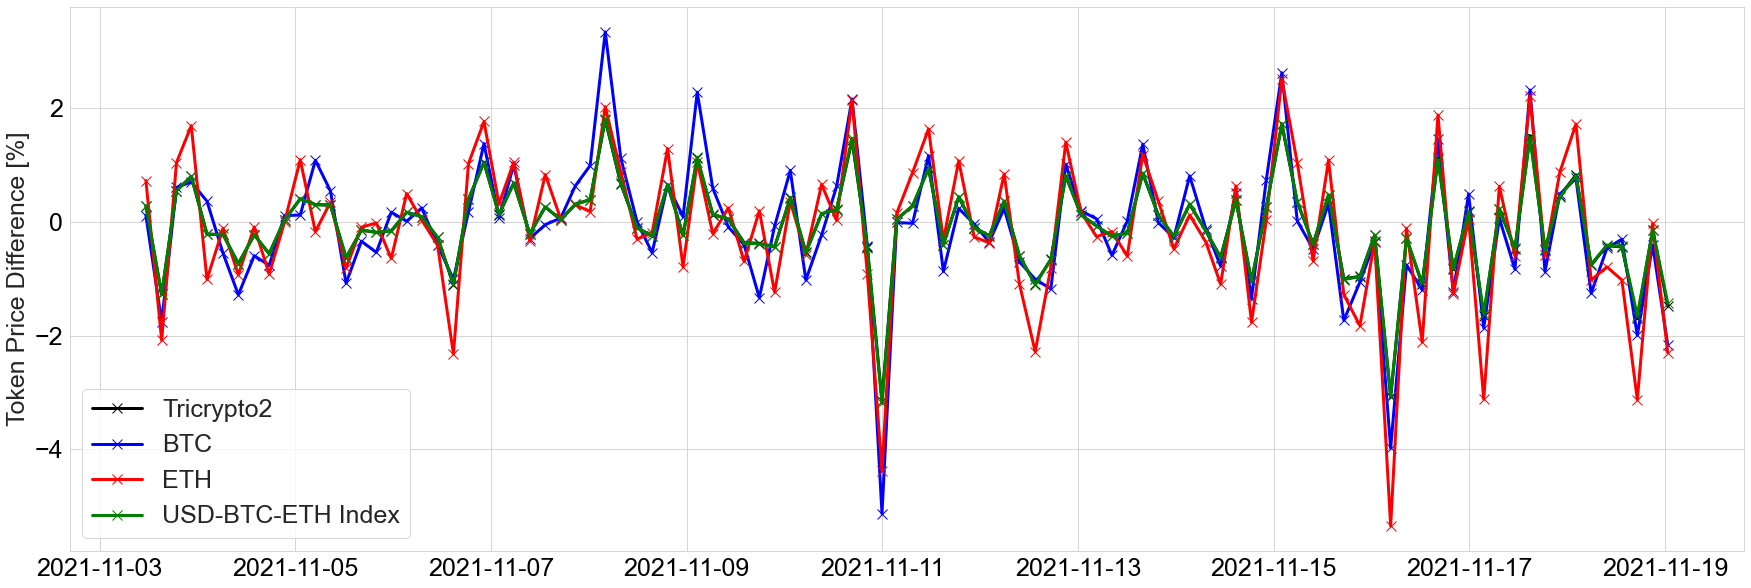

In [74]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

df_plot = df_prices.where(df_prices['lp_token_price'] > 0)

ax.plot(df_plot.index, df_plot.lp_token_price_diff_perc, 'kx-', lw=3, ms=10, label='Tricrypto2')
ax.plot(df_plot.index, df_plot.btc_price_diff_perc, 'bx-', lw=3, ms=10, label='BTC')
ax.plot(df_plot.index, df_plot.eth_price_diff_perc, 'rx-', lw=3, ms=10, label='ETH')
ax.plot(df_plot.index, df_plot.index_price_diff_perc, 'gx-', lw=3, ms=10, label='USD-BTC-ETH Index')

ax.set_ylabel("Token Price Difference [%]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.legend(fontsize=25);

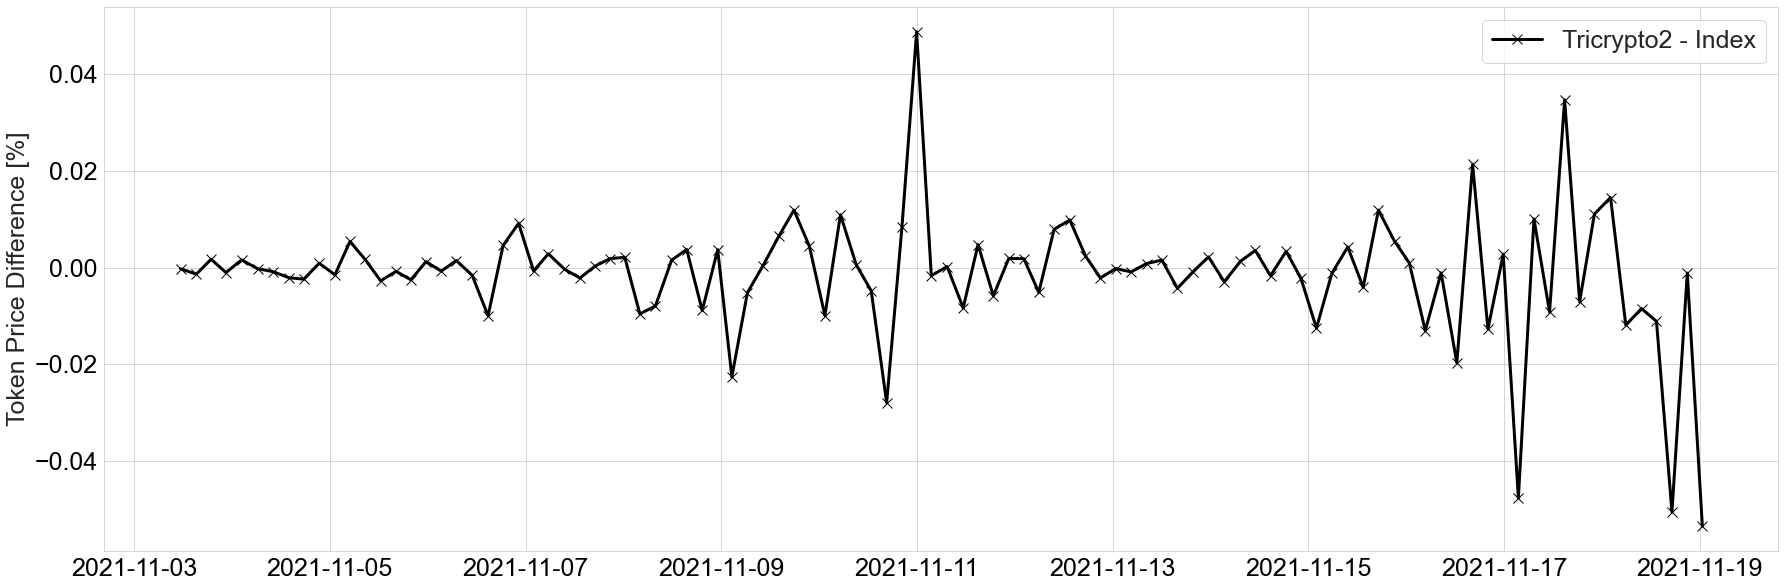

In [75]:
fig, ax = plt.subplots(1,1, figsize=(30, 10))

df_plot = df_prices.where(df_prices['lp_token_price'] > 0)

ax.plot(
    df_plot.index,
    df_plot.lp_token_price_diff_perc - df_plot.index_price_diff_perc,
    'kx-',
    lw=3,
    ms=10,
    label='Tricrypto2 - Index'
)

ax.set_ylabel("Token Price Difference [%]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.legend(fontsize=25);

Impermanent Loss

In [76]:
df_prices

,block_number,lp_token_price,btc_price,eth_price,index_price,lp_token_price_diff,btc_price_diff,eth_price_diff,index_price_diff,lp_token_price_diff_perc,btc_price_diff_perc,eth_price_diff_perc,index_price_diff_perc
timestamp,,,,,,,,,,,,,
2021-11-03 07:28:42,13542318,1989.749761,63022.853223,4553.708410,1989.749761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-03 11:22:53,13543318,1995.370904,63094.771896,4587.137534,1995.375599,5.621144,71.918673,33.429124,5.625838,0.281709,0.113985,0.728758,0.281944
2021-11-03 15:14:48,13544318,1970.254564,62005.081430,4493.609296,1970.285306,-25.116340,-1089.690466,-93.528238,-25.090293,-1.274776,-1.757421,-2.081361,-1.273434
2021-11-03 18:52:48,13545318,1981.194487,62385.197299,4541.017977,1981.190728,10.939922,380.115869,47.408682,10.905422,0.552188,0.609305,1.044010,0.550448
2021-11-03 22:30:34,13546318,1997.218537,62827.100773,4619.243652,1997.234911,16.024051,441.903473,78.225675,16.044183,0.802318,0.703364,1.693474,0.803320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-18 09:44:08,13638318,1909.606877,59676.810657,4247.522127,1909.939960,-7.938127,-274.576307,-33.563792,-7.778213,-0.415694,-0.460106,-0.790197,-0.407249
2021-11-18 13:24:04,13639318,1901.255852,59496.324531,4204.660177,1901.797667,-8.351025,-180.486126,-42.861950,-8.142293,-0.439237,-0.303357,-1.019392,-0.428137
2021-11-18 17:11:30,13640318,1869.555819,58334.804697,4077.258761,1871.017800,-31.700033,-1161.519834,-127.401416,-30.779867,-1.695592,-1.991127,-3.124683,-1.645087


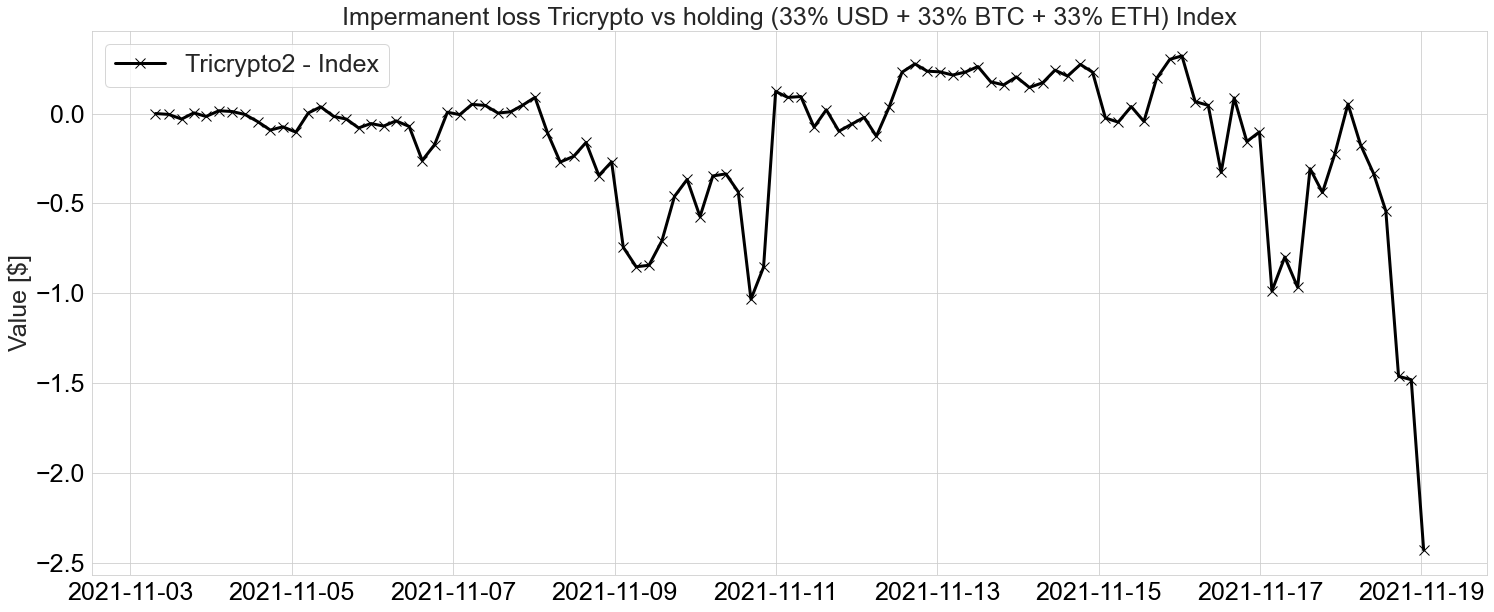

In [81]:
fig, ax = plt.subplots(1,1, figsize=(25, 10))

df_plot = df_prices.where(df_prices['lp_token_price'] > 0)

ax.plot(
    df_plot.index,
    df_plot.lp_token_price - df_plot.index_price,
    'kx-',
    lw=3,
    ms=10,
    label='Tricrypto2 - Index'
)

ax.set_ylabel("Value [$]", fontsize=25)
ax.set_title("Impermanent loss Tricrypto vs holding (33% USD + 33% BTC + 33% ETH) Index", fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.legend(fontsize=25);